## Hyperparameter tuning via Optuna

### Being a binary model this notebook will be limited to predicting one class 1 or 0, yes or no.
### Here I will be predicting if a cell received a treatment or not

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly
import seaborn as sns
import toml
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing

from sklearn.model_selection import train_test_split

sys.path.append("..")
from MLP_utils.parameters import Parameters
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve, auc


from MLP_utils.utils import (
    Dataset_formatter,
    data_split,
    extract_best_trial_params,
    objective_model_optimizer,
    optimized_model_create,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)

from utils.utils import df_stats
from MLP_utils.utils import parameter_set

In [2]:
# Import Data
# set data file path under pathlib path for multi-system use
file_path = Path(
    "../../Extracted_Features_(CSV_files)/interstellar_wave3_sc_norm_fs_cellprofiler.csv.gz"
)
df = pd.read_csv(file_path, engine="pyarrow")

In [3]:
data = Path("MLP_utils/config.toml")
config = toml.load(data)
params = Parameters()
params = parameter_set(params, config)

#### Set up Data to be compatible with model

##### Classification Models:
Comment out code if using regression

In [4]:
# Combine treatment with dosage to be able to discern treatments with different doses as a different condition
# Combine treatment and dose
df = df.assign(
    Metadata_Treatment_and_Dose=lambda x: df["Metadata_treatment"]
    + "_"
    + df["Metadata_dose"]
)

print("Unique Catagories are:")
print(df["Metadata_Treatment_and_Dose"].unique())

# Generate df specific to analysis and model
df = df.query(
    "Metadata_Treatment_and_Dose == 'LPS_10µg/ml'| Metadata_Treatment_and_Dose == 'Media only_0' | Metadata_Treatment_and_Dose == 'Disulfiram_2.5µM'"
)
# for binary classification testing
# df = df.query(
#     "Metadata_Treatment_and_Dose == 'LPS_10µg/ml'| Metadata_Treatment_and_Dose == 'Media only_0'"
# )
print("Selected Catagories are:")
print(df["Metadata_Treatment_and_Dose"].unique())
# Drop na and reindex accordingly
df = df.dropna()
df = df.reset_index(drop=True)

# Check for Nans again
df_stats(df)

# Understand categorical data such as treatment and dosing
df[["Metadata_Treatment_and_Dose"]].drop_duplicates()

if params.DATA_SUBSET_OPTION == "True":
    df = df.sample(n=params.DATA_SUBSET_NUMBER)
    print("Data Subset Is On")
    print(f"Data is subset to {params.DATA_SUBSET_NUMBER}")
else:
    print("Data Subset Is Off")

# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df[df_metadata]
df_values = df.drop(columns=df_metadata)

Unique Catagories are:
['LPS_10µg/ml' 'Disulfiram_2.5µM' 'LPS_1µg/ml' 'Disulfiram_0.1µM'
 'H2O2_500µM' 'Thapsi_10µM' 'H2O2_50µM' 'Thapsi_1µM' 'ATP_1mM'
 'LPS + Nigericin_1µg/ml + 10µM' 'ATP_0.1mM'
 'LPS + Nigericin_1µg/ml + 1µM' 'Flagellin_1µg/ml' 'DMSO 0.1%_0'
 'Flagellin_0.1µg/ml' 'Media only_0']
Selected Catagories are:
['LPS_10µg/ml' 'Disulfiram_2.5µM' 'Media only_0']
The dimensions of the data are: (50049, 569)
Number of total missing values across all columns: 0
Data Subset Is Off


In [5]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["Metadata_Treatment_and_Dose"] = le.fit_transform(
    df_descriptive["Metadata_Treatment_and_Dose"]
)
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop("Metadata_Treatment_and_Dose", axis=1)
df_values_Y = df_values["Metadata_Treatment_and_Dose"]

##### Regression Model Data Wrangling and Set Up
comment out if not using regression

In [6]:
# if params.DATA_SUBSET_OPTION == 'True':
#     df = df.sample(n=params.DATA_SUBSET_NUMBER)
#     print("yes")
# else:
#     pass
# df_stats(df)
# # Drop na and reindex accordingly
# df = df.dropna()
# df = df.reset_index(drop=True)

# # Check for Nans again
# df_stats(df)
# # Code snippet for metadata extraction by Jenna Tomkinson
# df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])
# # define which columns are data and which are descriptive
# df_descriptive = df[df_metadata]
# df_values = df.drop(columns=df_metadata)
# df_values_Y = df_values['Nuclei_Texture_InverseDifferenceMoment_CorrER_3_01_256']
# df_values_X = df_values.drop('Nuclei_Texture_InverseDifferenceMoment_CorrER_3_01_256', axis=1)

#### Split Data - All Models can proceed through this point

In [7]:
X_train, X_test, X_val, Y_train, Y_test, Y_val = data_split(
    X_vals=df_values_X,
    y_vals=df_values_Y,
    train_proportion=0.8,
    val_proportion=0.1,
    test_proportion=0.1,
    seed=1,
    params=params,
)

In [8]:
# produce data objects for train, val and test datasets
train_data = Dataset_formatter(
    torch.FloatTensor(X_train.values), torch.FloatTensor(Y_train.values)
)
val_data = Dataset_formatter(
    torch.FloatTensor(X_val.values), torch.FloatTensor(Y_val.values)
)
test_data = Dataset_formatter(
    torch.FloatTensor(X_test.values), torch.FloatTensor(Y_test.values)
)

In [9]:
params.IN_FEATURES = X_train.shape[1]
print("Number of in features: ", params.IN_FEATURES)
if params.MODEL_TYPE == "Regression":
    params.OUT_FEATURES = 1
else:
    params.OUT_FEATURES = len(df_values["Metadata_Treatment_and_Dose"].unique())

print("Number of out features: ", params.OUT_FEATURES)

if params.OUT_FEATURES > 2:
    params.MODEL_TYPE = "Multi_Class"
elif params.OUT_FEATURES == 2:
    params.OUT_FEATURES = params.OUT_FEATURES - 1
    params.MODEL_TYPE = "Binary_Classification"
elif params.OUT_FEATURES == 1:
    params.MODEL_TYPE = "Regression"
else:
    pass
print(params.MODEL_TYPE)

Number of in features:  555
Number of out features:  3
Multi_Class


In [10]:
# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=params.BATCH_SIZE
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=params.BATCH_SIZE
)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1)

In [11]:
# no accuracy function must be loss for regression
if params.MODEL_TYPE == "Regression":
    params.METRIC = "loss"
    params.DIRECTION = "minimize"
else:
    pass


# wrap the objective function inside of a lambda function to pass args...
objective_lambda_func = lambda trial: objective_model_optimizer(
    train_loader,
    valid_loader,
    trial=trial,
    params=params,
    metric=params.METRIC,
    return_info=False,
)


# Study is the object for model optimization
study = optuna.create_study(direction=f"{params.DIRECTION}")
# Here I apply the optimize function of the study to the objective function
# This optimizes each parameter specified to be optimized from the defined search space
study.optimize(objective_lambda_func, n_trials=params.N_TRIALS)
# Prints out the best trial's optimized parameters
objective_model_optimizer(
    train_loader,
    valid_loader,
    trial=study.best_trial,
    params=params,
    metric=params.METRIC,
    return_info=True,
)

[I 2023-04-12 08:55:15,476] A new study created in memory with name: no-name-39a313ac-5789-4570-99cf-4f3f2363da83
[I 2023-04-12 08:55:36,073] Trial 0 finished with value: 0.783629340926806 and parameters: {'n_layers': 2, 'n_units_l0': 4, 'dropout_0': 0.2635782466082889, 'n_units_l1': 6, 'dropout_1': 0.10401956981023165, 'learning_rate': 0.099393805399036, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.783629340926806.
[I 2023-04-12 08:55:55,122] Trial 1 finished with value: 0.9632613013188043 and parameters: {'n_layers': 3, 'n_units_l0': 7, 'dropout_0': 0.1709847551270531, 'n_units_l1': 4, 'dropout_1': 0.29305132307907017, 'n_units_l2': 2, 'dropout_2': 0.21384142704291526, 'learning_rate': 0.025468047474127956, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.783629340926806.
[I 2023-04-12 08:56:14,766] Trial 2 finished with value: 0.9088526328404744 and parameters: {'n_layers': 3, 'n_units_l0': 10, 'dropout_0': 0.2977125279659777, 'n_units_l1': 4, 'dropout_1': 0.1878479827235135

Validation Accuracy: 65.70829170829171
Validation Loss: 0.8256864160299302
Training Accuracy: 62.21703838757212
Training Loss: 0.8440469728010457


(65.70829170829171, 0.8256864160299302, 62.21703838757212, 0.8440469728010457)

In [12]:
fig = optuna.visualization.plot_optimization_history(study)
graph_path = f"./figures/{params.MODEL_TYPE}/plot_optimization_history_graph"
fig.write_html(Path(f"{graph_path}.html"))
fig.write_image(Path(f"{graph_path}.png"))
fig.show()

In [13]:
fig = optuna.visualization.plot_intermediate_values(study)
graph_path = f"./figures/{params.MODEL_TYPE}/plot_intermediate_values_graph"
fig.write_html(Path(f"{graph_path}.html"))
fig.write_image(Path(f"{graph_path}.png"))
fig.show()

In [14]:
# call function for best trial parameter extraction
param_dict = extract_best_trial_params(study.best_params)

In [15]:
# call the optimized training model
train_loss, train_acc, valid_loss, valid_acc, epochs_ran, model = train_optimized_model(
    params.TRAIN_EPOCHS,
    train_loader,
    valid_loader,
    param_dict,
    params,
)
if params.MODEL_TYPE == "Regression":
    training_stats = pd.DataFrame(
        zip(train_loss, valid_loss, epochs_ran),
        columns=["train_loss", "valid_loss", "epochs_ran"],
    )
else:
    training_stats = pd.DataFrame(
        zip(train_loss, train_acc, valid_loss, valid_acc, epochs_ran),
        columns=["train_loss", "train_acc", "valid_loss", "valid_acc", "epochs_ran"],
    )

SGD
Epoch 0: Validation loss decreased (inf --> 1.031790).  Saving model ...
	 Train_Loss: 1.0742 Train_Acc: 41.425 Val_Loss: 1.0318  BEST VAL Loss: 1.0318  Val_Acc: 49.910

Epoch 1: Validation loss decreased (1.031790 --> 1.012831).  Saving model ...
	 Train_Loss: 1.0483 Train_Acc: 45.623 Val_Loss: 1.0128  BEST VAL Loss: 1.0128  Val_Acc: 51.548

Epoch 2: Validation loss decreased (1.012831 --> 0.999585).  Saving model ...
	 Train_Loss: 1.0321 Train_Acc: 47.803 Val_Loss: 0.9996  BEST VAL Loss: 0.9996  Val_Acc: 52.088

Epoch 3: Validation loss decreased (0.999585 --> 0.987768).  Saving model ...
	 Train_Loss: 1.0187 Train_Acc: 50.538 Val_Loss: 0.9878  BEST VAL Loss: 0.9878  Val_Acc: 56.943

Epoch 4: Validation loss decreased (0.987768 --> 0.977327).  Saving model ...
	 Train_Loss: 1.0078 Train_Acc: 52.509 Val_Loss: 0.9773  BEST VAL Loss: 0.9773  Val_Acc: 59.001

Epoch 5: Validation loss decreased (0.977327 --> 0.967558).  Saving model ...
	 Train_Loss: 0.9982 Train_Acc: 53.795 Val_Loss:

/home/lippincm/Documents/ML/Interstellar_Analysis/MLP_Model/MLP_utils/utils.py:874: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/home/lippincm/Documents/ML/Interstellar_Analysis/MLP_Model/MLP_utils/utils.py:875: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



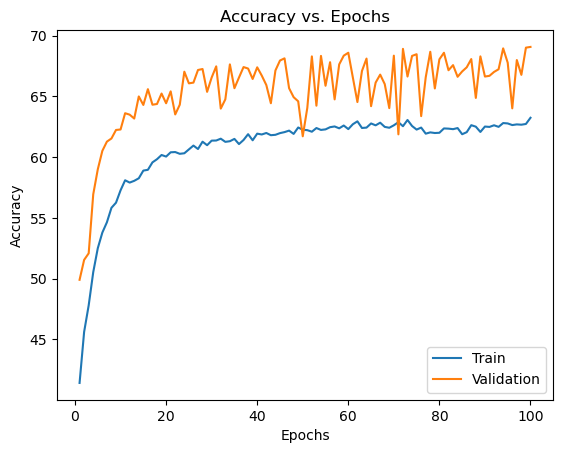

In [16]:
if params.MODEL_TYPE == "Regression":
    pass
else:
    plot_metric_vs_epoch(
        training_stats,
        x="epochs_ran",
        y1="train_acc",
        y2="valid_acc",
        title="Accuracy vs. Epochs",
        x_axis_label="Epochs",
        y_axis_label="Accuracy",
        params=params,
    )

/home/lippincm/Documents/ML/Interstellar_Analysis/MLP_Model/MLP_utils/utils.py:874: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/home/lippincm/Documents/ML/Interstellar_Analysis/MLP_Model/MLP_utils/utils.py:875: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



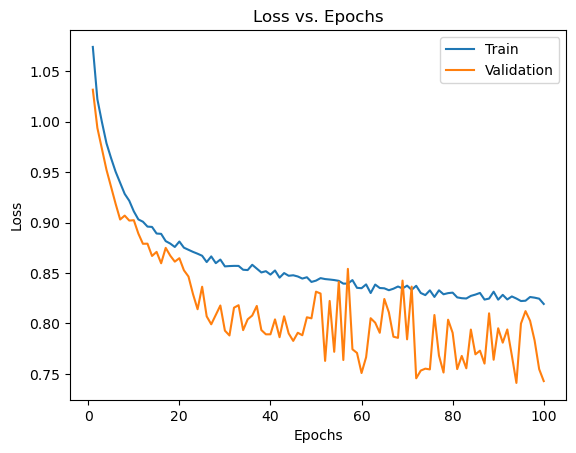

In [17]:
plot_metric_vs_epoch(
    training_stats,
    x="epochs_ran",
    y1="train_loss",
    y2="valid_loss",
    title="Loss vs. Epochs",
    x_axis_label="Epochs",
    y_axis_label="Loss",
    params=params,
)

In [18]:
# calling the testing function and outputting list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    y_pred_list = test_optimized_model(model, test_loader, params)
elif params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(model, test_loader, params)
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

              precision    recall  f1-score   support

           0       0.69      0.62      0.65      1346
           1       0.64      0.60      0.62      1768
           2       0.70      0.79      0.74      1891

    accuracy                           0.68      5005
   macro avg       0.68      0.67      0.67      5005
weighted avg       0.68      0.68      0.68      5005

Precision for class 0: 0.686530612244898
Recall for class 0: 0.62481426448737
Precision for class 1: 0.6412121212121212
Recall for class 1: 0.5984162895927602
Precision for class 2: 0.7028169014084507
Recall for class 2: 0.7916446324695928
3


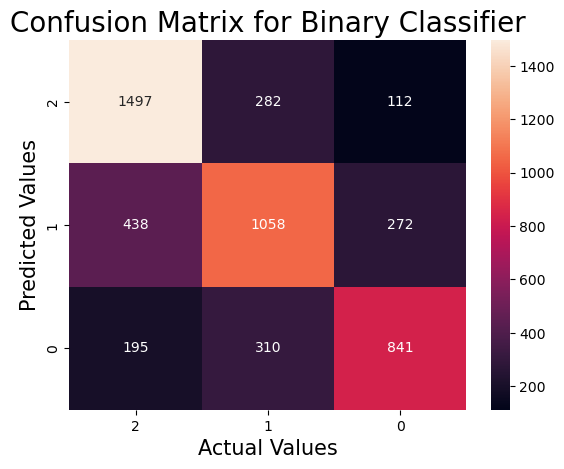

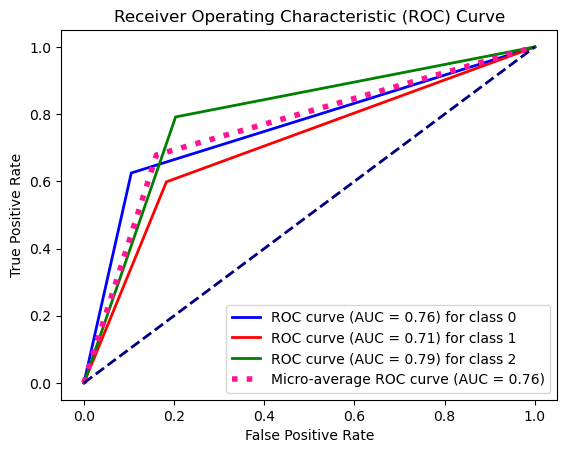

In [19]:
# Call visualization function
# calling the testing function and outputing list values of tested model
if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
    confusion_matrix_df = results_output(y_pred_list, Y_test, params)
elif params.MODEL_TYPE == "Binary_Classification":
    results_output(y_pred_list, Y_test, params, y_pred_prob_list)
else:
    raise Exception("Model type must be specified for proper model testing")